# Lab: Style Transfer

By: Lawrence (Jake) Klinkert and Hongjin (Tony) Yu

CS8321 Sect 001 1222

3/27/2022

Submission Details: Turn in the rendered jupyter notebook (exported as HTML) to canvas. Only one notebook per team is required, but team names must be on the assignment.

If using code from another author (not your own), you will be graded on the clarity of explanatory comments you add to the code. 

In [23]:
from PIL import Image
import requests

TRAINING = True
EVALUATE = True

In this lab you will implement a style transfer algorithm with whitening and coloring transformations, using the work of Li et al. in their universal style transfer paper. An example implementation of training a decoder for different scales of VGG has been implemented for you to build from (https://github.com/8000net/universal-style-transfer-keras to an external site.). However, you will be manipulating the code to work properly. Also, the code should be updated to work with the newest version of Keras/Tensorflow. As always, you can choose a PyTorch implementation if you prefer.

[2 Points] Look at the above decoder code and describe any errors (or imperfections) in the upsampling layers. Discuss how these errors could be fixed. Now implement these solutions either by updating the code or rewriting the implementation. Remember that you should use strided convolutions without any pooling steps (i.e., do NOT use unpooling). You can also use another network besides VGG if you desire (such as UNET, for example). If using a new network, be sure it uses only feedforward connections (for simplicity). 

#### Original Code to refrence

In [24]:
from keras.layers import Input, Conv2D, UpSampling2D

def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

#### Architecture of encoder-decoder convolutional neural network for Vgg19

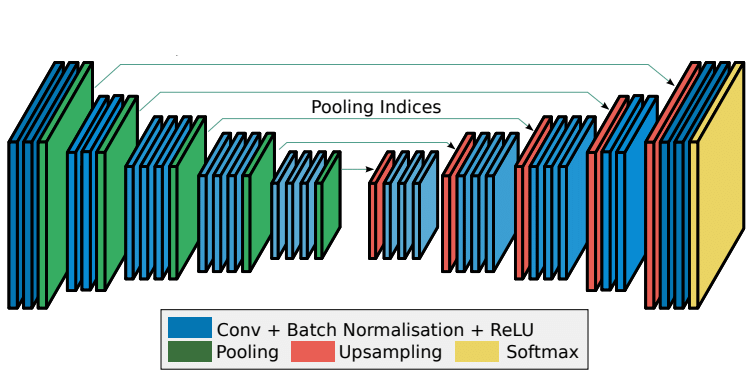

In [25]:
Image.open(requests.get("https://www.researchgate.net/profile/Arsal-Syed-2/publication/335495371/figure/fig2/AS:892800157638656@1589871553065/SegNets-encoder-decoder-architecture-based-off-VGG16-with-fully-connected-layers-removed.ppm", stream=True).raw)

Image of VGG16 encoder-decoder architecture

#### Errors and Imperfections

From the above code and figure showing the architecture of VGG16, we can determine the correct structure of the decoder. For Major errors with the code, the decoder is not a reflection of the encoder. For start, the layering order is reversed in the decoder, and does not capture an entire block. Second, the number of convolutional layers per block are wrong, it should be 4, 4, 4, 2, 2. There is no softmax activation at the end of the decoder. Finally, a minor issue is that if the user does not provide a layer that is between 1 and 5, then the model will not return anything.

#### Refactor

In [26]:
# decoder.py

def decoder_layers(inputs, layer):
    if layer == 5:
        x = vgg_block_reverse(layer_in=inputs, n_filter=512, n_conv=4, block_number=5, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=512, n_conv=4, block_number=4, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=256, n_conv=4, block_number=3, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=128, n_conv=2, block_number=2, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=64, n_conv=2, block_number=1, trainable=True)
        return x

    if layer == 4:
        x = vgg_block_reverse(layer_in=inputs, n_filter=512, n_conv=4, block_number=4, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=256, n_conv=4, block_number=3, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=128, n_conv=2, block_number=2, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=64, n_conv=2, block_number=1, trainable=True)
        return x

    if layer == 3:
        x = vgg_block_reverse(layer_in=inputs, n_filter=256, n_conv=4, block_number=3, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=128, n_conv=2, block_number=2, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=64, n_conv=2, block_number=1, trainable=True)
        return x

    if layer == 2:
        x = vgg_block_reverse(layer_in=inputs, n_filter=128, n_conv=2, block_number=2, trainable=True)
        x = vgg_block_reverse(layer_in=x, n_filter=64, n_conv=2, block_number=1, trainable=True)
        return x

    if layer == 1:
        x = vgg_block_reverse(layer_in=inputs, n_filter=64, n_conv=2, block_number=1, trainable=True)
        return x





In [27]:
#vgg.py
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, BatchNormalization
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
def vgg_layers(inputs, target_layer):
    # Block 1
    x = vgg_block(inputs, n_filter=64, n_conv=2, block_number=1, trainable=False)
    if target_layer == 1:
        return x

    # Block 2
    x = vgg_block(x, n_filter=128, n_conv=2, block_number=2, trainable=False)
    if target_layer == 2:
        return x

    # Block 3
    x = vgg_block(x, n_filter=256, n_conv=4, block_number=3, trainable=False)
    if target_layer == 3:
        return x

    # Block 4
    x = vgg_block(x, n_filter=512, n_conv=4, block_number=4, trainable=False)
    if target_layer == 4:
        return x

    # Block 5
    x = vgg_block(x, n_filter=512, n_conv=4, block_number=5, trainable=False)
    return x


def vgg_block(layer_in, n_filter, n_conv, block_number, trainable=True):
    for conv_num in range(n_conv):
        layer_in = Conv2D(n_filter, (3, 3), activation='relu', padding='same', name=f'encode_block{block_number}_conv{conv_num}')(layer_in)
        layer_in.trainable = trainable
        layer_in = BatchNormalization()(layer_in)
        layer_in.trainable = trainable
    layer_in = MaxPooling2D((2, 2), strides=(2, 2), name=f'encode_block{block_number}_pool')(layer_in)
    layer_in.trainable = trainable
    layer_in = BatchNormalization()(layer_in)
    layer_in.trainable = trainable
    return layer_in


def vgg_block_reverse(layer_in, n_filter, n_conv, block_number, trainable=True):
    layer_in = UpSampling2D((2, 2), name=f'decode_block{block_number}_upsample')(layer_in)
    layer_in.trainable = trainable
    layer_in = BatchNormalization()(layer_in)
    layer_in.trainable = trainable

    for conv_num in range(n_conv):
        layer_in = Conv2D(n_filter, (3, 3), activation='relu', padding='same', name=f'decode_block{block_number}_conv{conv_num}')(layer_in)
        layer_in.trainable = trainable
        layer_in = BatchNormalization()(layer_in)
        layer_in.trainable = trainable
    return layer_in


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH, 'r')
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

In [32]:
#model.py
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

LAMBDA = 1.0


def l2_loss(x):
    return K.sum(K.square(x)) / 2


class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5, decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer
        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        self.history = None

        if decoder_path:
            decoder_name = f"decoder_{target_layer}_model.h5"
            decoder_history = f"decoder_{target_layer}_history.npy"
            decoder_full_path = os.path.join(decoder_path, decoder_name)
            history_full_path = os.path.join(decoder_path, decoder_history)
            self.decoder = load_model(decoder_full_path)
            self.history = np.load(history_full_path, allow_pickle=True).item()
        else:
            self.decoder = self.create_decoder(target_layer)

        self.inputs = Input(self.input_shape)
        print("self.inputs: ")
        print(self.inputs)
        inputs = Input(shape=self.input_shape, name='img_input')
        code = self.encoder(inputs)
        reconstruction = self.decoder(code)
        self.model = Model(inputs, reconstruction)
        self.model.compile(loss=self.loss_function, optimizer='adamax')
        print(self.model.summary())

    def loss_function(self, y_true, y_pred):
        encoding_in = self.encoder(y_true)
        encoding_out = self.encoder(y_pred)
        
        # L2 normalization before L2 loss
        en_in_norm = encoding_in / K.sqrt(K.sum(K.pow(encoding_in, 2)))
        en_out_norm = encoding_out / K.sqrt(K.sum(K.pow(encoding_out, 2)))
        y_pred_norm = y_pred / K.sqrt(K.sum(K.pow(y_pred, 2)))
        y_true_norm = y_true / K.sqrt(K.sum(K.pow(y_true, 2)))

        return l2_loss(y_pred_norm - y_true_norm) + LAMBDA * l2_loss(en_out_norm - en_in_norm)

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:])
        print(inputs)
        layers = decoder_layers(inputs, target_layer)
        print("decoder layer is:")
        print(layers)
        output = Conv2D(3, (3, 3), activation='Softmax', padding='same', name='decoder_out')(layers)
        print("output:")
        print(output)

        # updating model and loss for decoder
        model = Model(inputs, output, name='decoder_%s' % target_layer)
        #        model.add_loss(self.loss)
        return model

    def Fit_Dataset(self, x, y, epochs, verbose):
        self.history = self.model.fit(x=x, y=y, epochs=epochs, verbose=verbose)

    def Fit_Generator(self, gen, train_steps, test_steps, epochs, verbose):
        self.history = self.model.fit_generator(gen[0], steps_per_epoch=train_steps, validation_data = gen[1], validation_steps = test_steps, epochs=epochs, verbose=verbose)

    def export_decoder(self, rel_dir):
        cwd = os.getcwd()

        file_model_name = f'decoder_{self.target_layer}_model.h5'
        full_path = os.path.join(cwd, rel_dir)
        model_full_path = os.path.join(full_path, file_model_name)
        self.decoder.save(model_full_path)

        file_history_name = f'decoder_{self.target_layer}_history.npy'
        history_full_path = os.path.join(full_path, file_history_name)
        np.save(history_full_path, self.history.history)


    def Plot_History(self):
        plt.title("Decoder Loss")
        plt.plot(self.history['loss'], color="red")
        plt.plot(self.history['val_loss'], color="blue")
        plt.xlabel("Epoch")
        plt.show()


In [34]:
#train.py
import sys
import os
from skimage.util import random_noise


os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To run on CPU, uncomment this line

import numpy as np

from keras.preprocessing import image
from keras.callbacks import Callback
from PIL import Image
import cv2
#from model import EncoderDecoder
import zipfile

ZIP_PATH = 'data/RafD_resized.zip'
UNZIP_PATH = 'data/'

TARGET_LAYER = 2
IMAGE_PATH = "data/RafD_test"
#IMAGES_PATH = 'data/RafD_train'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 32

cwd = os.getcwd()


def create_gen(train_img_dir, target_size, batch_size, validation_split=0.2):
    datagen = image.ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    train_gen = datagen.flow_from_directory(directory=train_img_dir, target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode="input", shuffle = True, interpolation = "bilinear", subset='training', seed = 123)
    validation_gen = datagen.flow_from_directory(directory=train_img_dir, target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode="input", shuffle = True, interpolation = "bilinear", subset='validation', seed = 123)

    def train_tuple_gen():
        for img in train_gen:
            #if img != batch_size:
            #    continue

            # (X, y)
            yield img

    def val_tuple_gen():
        for img in validation_gen:
            #if img != batch_size:
            #    continue

            # (X, y)
            noise_img = random_noise(img[0], mode='s&p',amount=0.1)
            noise_img = np.array(255*noise_img, dtype = 'uint8')
            yield (noise_img, img[1])

    return train_tuple_gen(), val_tuple_gen()


# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        # test_img = image.load_img(test_img_path)
        # test_img = imresize(test_img, (256, 256, 3))
        text_img = cv2.imread(test_img_path, 1)
        # text_img_resize = cv2.resize(src=text_img, dsize=(256, 256))
        text_img_resize = cv2.resize(src=text_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        test_target = image.img_to_array(text_img_resize)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if self.iteration % self.increment == 0:
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            #imwrite(out_path, output_img)
            im = Image.fromarray(output_img)
            im.save(out_path)

        self.iteration += 1


if TRAINING:

    zip_full_path = os.path.join(cwd, ZIP_PATH)
    unzip_full_path = os.path.join(cwd, UNZIP_PATH)
    with zipfile.ZipFile(zip_full_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_full_path)

    image_full_path = os.path.join(cwd, IMAGE_PATH)
    gen = create_gen(image_full_path, TARGET_SIZE, BATCH_SIZE)

    #original_images = np.asarray(load_images_from_folder(IMAGE_PATH), dtype=np.float16)
    #image_full_path = os.path.join(cwd, IMAGE_PATH)
    #original_image = image.load_img(image_full_path, target_size=(256, 256, 3))
    #original_array = image.img_to_array(original_image)
    #print(original_array.shape)
    #input_images = np.expand_dims(original_array, axis=0)
    #print(input_images.shape)

    #num_samples = 4752
    num_train_samples = np.round(72.0 * 0.8)
    num_test_samples = np.round(72.0 * 0.2)
    train_steps_per_epoch = num_train_samples // BATCH_SIZE
    test_steps_per_epoch = num_test_samples // BATCH_SIZE


    # argv[1] is the layer we wish to train [1, 5]
    #target_layer = int(sys.argv[1])
    target_layer = TARGET_LAYER
    encoder_decoder = EncoderDecoder(target_layer=target_layer)
    # encoder_decoder.model.fit(gen, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=callbacks)
    #encoder_decoder.model.fit(x=input_images, y=input_images, epochs=EPOCHS, verbose=1)
    # encoder_decoder.export_decoder()

    #encoder_decoder.Fit_Dataset(x=input_images, y=input_images, epochs=EPOCHS, verbose=1)
    encoder_decoder.Fit_Generator(gen, train_steps_per_epoch, test_steps_per_epoch, epochs=EPOCHS, verbose=1)
    #callbacks = [OutputPreview(encoder_decoder, IMAGE_PATH, 5000, './preview-%d' % target_layer)]
    #encoder_decoder.model.fit_generator(x=gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, verbose=1)
    encoder_decoder.export_decoder('models/')
    print("finished!")

Found 58 images belonging to 1 classes.
Found 14 images belonging to 1 classes.
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name='input_44'), name='input_44', description="created by layer 'input_44'")
decoder layer is:
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='batch_normalization_179/FusedBatchNormV3:0', description="created by layer 'batch_normalization_179'")
output:
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='decoder_out/softmax_14/Softmax:0', description="created by layer 'decoder_out'")
self.inputs: 
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_45'), name='input_45', description="created by layer 'input_45'")
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 256,

C:\Users\JAKEKL~1\AppData\Local\Temp/ipykernel_30280/462566863.py:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.history = self.model.fit_generator(gen[0], steps_per_epoch=train_steps, validation_data = gen[1], validation_steps = test_steps, epochs=epochs, verbose=verbose)


7/7 [==============================] - 85s 11s/step - loss: 1.7156 - val_loss: 1.6326
Epoch 2/32
7/7 [==============================] - 75s 12s/step - loss: 1.5351 - val_loss: 1.6218
Epoch 3/32
7/7 [==============================] - 76s 11s/step - loss: 1.5295 - val_loss: 1.6187
Epoch 4/32
7/7 [==============================] - 77s 11s/step - loss: 1.5266 - val_loss: 1.6173
Epoch 5/32
7/7 [==============================] - 73s 10s/step - loss: 1.5228 - val_loss: 1.6129
Epoch 6/32
7/7 [==============================] - 72s 10s/step - loss: 1.5199 - val_loss: 1.6091
Epoch 7/32
7/7 [==============================] - 68s 10s/step - loss: 1.5179 - val_loss: 1.6086
Epoch 8/32
7/7 [==============================] - 69s 10s/step - loss: 1.5173 - val_loss: 1.6080
Epoch 9/32
7/7 [==============================] - 75s 11s/step - loss: 1.5159 - val_loss: 1.6065
Epoch 10/32
7/7 [==============================] - 69s 11s/step - loss: 1.5158 - val_loss: 1.6058
Epoch 11/32
7/7 [=======================

self.inputs: 
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_47'), name='input_47', description="created by layer 'input_47'")
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 64, 64, 128)       262464    
                                                                 
 decoder_2 (Functional)      (None, 256, 256, 3)       410179    
                                                                 
Total params: 672,643
Trainable params: 670,211
Non-trainable params: 2,432
_________________________________________________________________
None


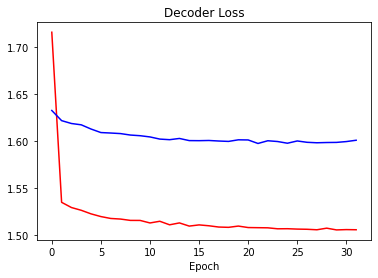

In [35]:
#evaluate-decoder.py
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
#from imageio import imwrite
from keras.preprocessing import image
from PIL import Image

#from model import EncoderDecoder

if EVALUATE:
    LAYER = 2

    cwd = os.getcwd()

    #from testing
    DECODER_PATH = f'models/'
    INPUT_IMG_PATH = 'data/RafD_test/train/Rafd045_01_Caucasian_female_angry_frontal.jpg'
    OUTPUT_IMG_PATH = f'models/Rafd045_01_Caucasian_female_angry_frontal_layer_{LAYER}.jpg'

    #from maneframe
    #DECODER_PATH = f'models/maneframe'
    #INPUT_IMG_PATH = 'data/RafD_train/train/Rafd045_02_Caucasian_female_angry_frontal.jpg'
    #OUTPUT_IMG_PATH = f'models/Rafd045_02_Caucasian_female_angry_frontal_layer_{LAYER}.jpg'


    decoder_full_path = os.path.join(cwd, DECODER_PATH)
    encoder_decoder = EncoderDecoder(target_layer=LAYER, decoder_path=decoder_full_path)

    input_full_path = os.path.join(cwd, INPUT_IMG_PATH)
    original_images = image.load_img(input_full_path, target_size=(256, 256, 3))
    original_array = image.img_to_array(original_images)
    #image.array_to_img(original_array).show()
    input_images = np.expand_dims(original_array, axis=0)

    output_img = encoder_decoder.model.predict([input_images])
    #image.array_to_img(output_img[0]).show()

    output_full_path = os.path.join(cwd, OUTPUT_IMG_PATH)
    image.save_img(path=output_full_path, x=output_img[0], data_format="channels_last")
    #im = Image.fromarray(output_img)
    #
    #im.save(output_full_path)

    encoder_decoder.Plot_History()
    

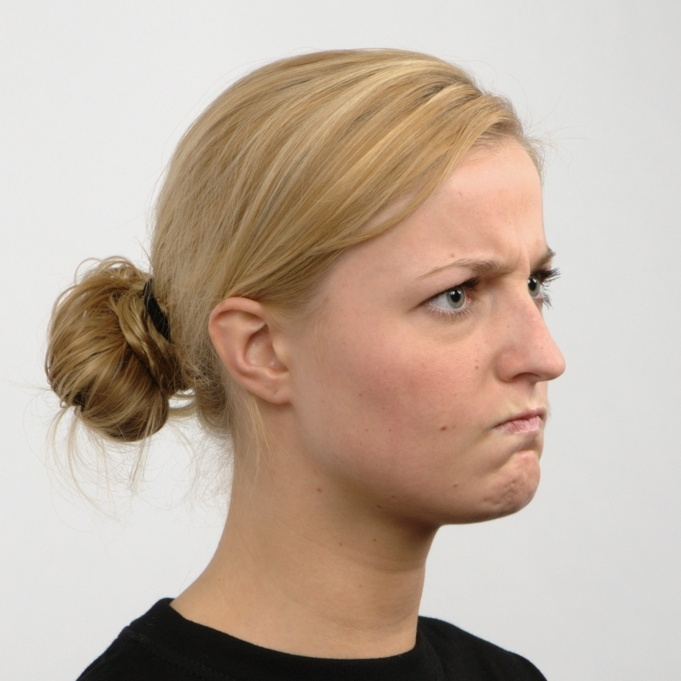

In [36]:
Image.open(input_full_path)

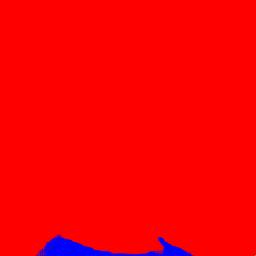

In [37]:
Image.open(output_full_path)

In [42]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


visualize(input_full_path,encoder_decoder.encoder,encoder_decoder.decoder)

IndexError: list index out of range

This is just a test to ensure that the model works. The encoder and decoder code sections above have been created into scripts, and sent to 

[5 Points] Train two (or more) image decoders that can decode an image from two different convolutional layers from VGG (or whatever network you want).  You should choose one reconstruction from an early layer (like block 1 or 2 in VGG) and from a later layer (like block 3 or later in VGG).

In [ ]:
Image.open(requests.get("https://miro.medium.com/max/1034/1*urbx5J1WFhjA9jcYCqnIBg.png", stream=True).raw)

Since we are taking a Multi-level stylization approach for style transfer, shown in the figure above, we've choosen to train layers 2 and 3. This way we can connect them together in series to see the next level of details, rather than jumping from layers further away from eachother.

If using Keras, there is starter code available at the link above. You may use any image dataset you like for training. One nice option might be the labeled faces in the wild dataset, available in scikit-learn. This is a modest sized dataset, but is only of faces, which can help speed along training because of the reduced variability. 

For the loss function, be sure to use both the L2 loss of the reconstructed image and the encoder representation (i.e., image loss and feature loss).

Note, decoding training can be sped up significantly by manipulating the above code to train multiple decoders in the same pass.

If your auto encoder fails to converge, you may use pre-trained image decoder weights (from anywhere online). Be sure to cite any code or weights you use properly. For example, you can use the pre-trained auto encoder from class: 
<ul>
<li> https://github.com/8000net/LectureNotesMaster/blob/master/03c%20UniversalStyleTransfer.ipynbLinks to an external site. </li>
<li> Model Weights (large files!!): https://www.dropbox.com/sh/2djb2c0ohxtvy2t/AAAxA2dnoFBcHGqfP0zLx-Oua?dl=0Links to an external site. 
<li> A slightly reduced grade will be given for using pre-trained encoder/decoder pairs. However, it is better to use an existing implementation rather than an implementation that failed to converge. </li>
<li> The GitHub link from Yihao Wang, who wrote this implementation: https://github.smu.edu/48066464/CS8321Lab2_DecoderLinks to an external site. </li>
</ul>

Plot both training and validation losses versus the number of epochs to show that the training has converged. 


In [ ]:
# Plot training loss over time

[1 Points] Show a few images and their reconstructions using each decoder. Comment on any artifacts from the images. For full credit, the decoding of the images should look similar and the performance should be discussed. 

[1 Points] Implement the whitening and coloring transform (WCT) as described by Li et al. An implementation of this has already been written for you, available in the link above and in the class master repository.  You should use an SVD decomposition of the covariance (NOT an SVD of the activations). 

Show a few images that are style transferred using this method and describe their quality.  

Implement three of following additions to the style network. You may choose any three from this list. Each implementation is worth 2 points. Doing more than three will not result in extra credit. Only the first three implementations in your notebook will be graded. You should describe the results of each style transfer implementation in detail to receive full credit. 

<ul>
<li> [2 points] Implement the smoothing constraint from Li et al. to achieve more photo realistic style transfer results. Show a few photo-realistic style changes from the network. </li>
<li> [2 points] Perform style transfer with an image mask, where each segmented portion of the image is given a different style. Show a few images with multiple styles applied to the different segmented patches. </li>
<li> [2 points] Implement a different covariance matching algorithm. You can use any covariance matching algorithm you want. For example, see the discussion here: https://openaccess.thecvf.com/content_ICCV_2019/papers/Lu_A_Closed-Form_Solution_to_Universal_Style_Transfer_ICCV_2019_paper.pdfLinks to an external site. </li>
<li> [2 points] When using multiple style images, manipulate the decoder to blend different styles in the reconstruction. That is, use the methods from Li et al. in reconstructing from multiple style images by linearly blending the different outputs from each style-decoded image.</li>
<li> [2 points] Implement a color preserving style transfer. That is, manipulate the content image to be in HSV space, then style the V channel only. Combine back with the H and S channels using appropriate blurring. Show a few images with and without color preservations to verify that color is preserved better.</li>
<li> [2 points] Implement a style transfer addition of your choosing (or something from the literature). If selecting this option, reach out to the instructor to be sure the addition is of sufficient complexity.  </li>
</ul>